# Demonstration of different limiters for advection
This notebook shows the effect of limiters on advection for various initial conditions.  It includes the results for first and second order methods from Figures 6.1-6.3 of [Finite Volume Methods for Hyperbolic Problems](http://depts.washington.edu/clawpack/book.html), as well as results for WENO methods.

In [3]:
%matplotlib inline
import numpy as np
from clawpack import pyclaw
from clawpack import riemann
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from clawpack.visclaw.JSAnimation import IPython_display

The function below sets up an advection simulation with the specified scheme, on the unit interval with periodic boundary conditions.  Since output is written at integer times, the solution at each output time has been advected precisely back to its original location.  Plotting each frame shows us how the solution is modified by numerical effects as it moves once through the domain.

In [7]:
def setup(scheme='minmod',cfl_max=0.9,IC='gauss_square',mx=100):
    if 'weno' in scheme:
        solver = pyclaw.SharpClawSolver1D(riemann.advection_1D)
    else:
        solver = pyclaw.ClawSolver1D(riemann.advection_1D)

    solver.bc_lower[0] = pyclaw.BC.periodic
    solver.bc_upper[0] = pyclaw.BC.periodic
    
    if scheme in ('minmod','superbee','MC','vanleer'):
        solver.limiters = getattr(pyclaw.limiters.tvd,scheme)
    #elif scheme == 'CT':
        #solver.limiters = pyclaw.limiters.tvd.cada_torrilhon_limiter
    elif scheme == 'Lax-Wendroff':
        solver.limiters = 0
    elif scheme == 'first-order':
        solver.order = 1
    elif 'weno' in scheme:
        solver.weno_order = int(scheme[4:]) #weno5, weno7, ...
    else:
        raise Exception('Unrecognized limiter')

    solver.cfl_max = cfl_max
    solver.cfl_desired = cfl_max*0.9

    x = pyclaw.Dimension(0.0,1.0,mx,name='x')
    domain = pyclaw.Domain(x)
    num_eqn = 1
    state = pyclaw.State(domain,num_eqn)
    state.problem_data['u']=1.

    grid = state.grid
    xc = grid.x.centers
    if IC=='gauss_square':
        beta=200.; x0=0.3
        state.q[0,:] = np.exp(-beta * (xc-x0)**2) + (xc>0.6)*(xc<0.8)
    elif IC=='wavepacket':
        beta=100.; x0=0.5
        state.q[0,:] = np.exp(-beta * (xc-x0)**2) * np.sin(80.*xc)
    else:
        raise Exception('Unrecognized initial condition.')

    claw = pyclaw.Controller()
    claw.solution = pyclaw.Solution(state,domain)
    claw.solver = solver
    claw.keep_copy = True
    claw.output_format = None

    claw.tfinal =10.0
    return claw

### Gaussian and square wave

In [8]:
results = []
schemes = ('first-order','Lax-Wendroff','minmod','superbee','MC','vanleer','weno5','weno7','weno9')
for scheme in schemes:
    claw = setup(scheme=scheme)
    claw.run()
    results.append(claw.frames)

2019-06-24 12:25:46,517 INFO CLAW: Solution 0 computed for time t=0.000000
2019-06-24 12:25:46,529 INFO CLAW: Solution 1 computed for time t=1.000000
2019-06-24 12:25:46,539 INFO CLAW: Solution 2 computed for time t=2.000000
2019-06-24 12:25:46,549 INFO CLAW: Solution 3 computed for time t=3.000000
2019-06-24 12:25:46,559 INFO CLAW: Solution 4 computed for time t=4.000000
2019-06-24 12:25:46,568 INFO CLAW: Solution 5 computed for time t=5.000000
2019-06-24 12:25:46,578 INFO CLAW: Solution 6 computed for time t=6.000000
2019-06-24 12:25:46,588 INFO CLAW: Solution 7 computed for time t=7.000000
2019-06-24 12:25:46,597 INFO CLAW: Solution 8 computed for time t=8.000000
2019-06-24 12:25:46,608 INFO CLAW: Solution 9 computed for time t=9.000000
2019-06-24 12:25:46,617 INFO CLAW: Solution 10 computed for time t=10.000000
2019-06-24 12:25:46,619 INFO CLAW: Solution 0 computed for time t=0.000000
2019-06-24 12:25:46,630 INFO CLAW: Solution 1 computed for time t=1.000000
2019-06-24 12:25:46,643

2019-06-24 12:26:32,774 INFO CLAW: Animation.save using <class 'clawpack.visclaw.JSAnimation.html_writer.HTMLWriter'>



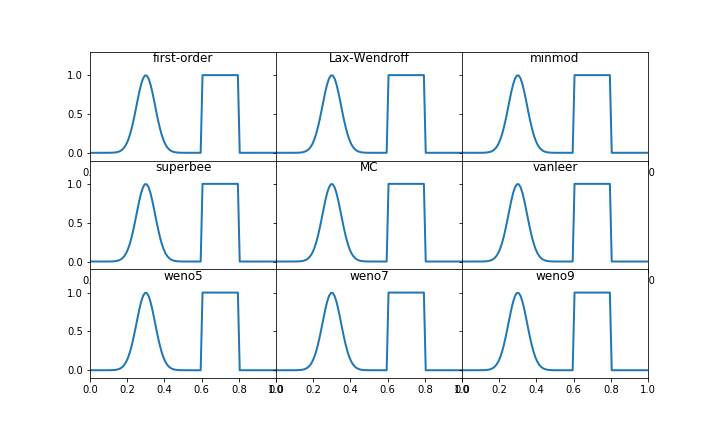
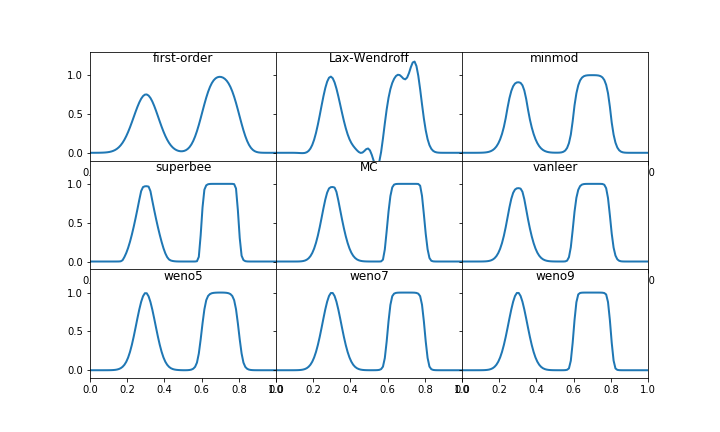
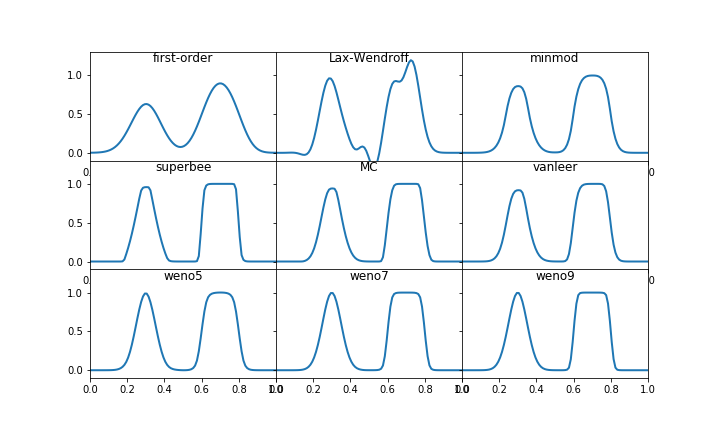
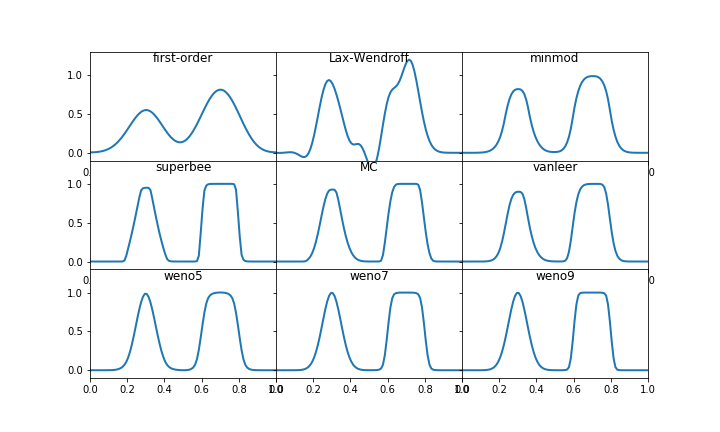
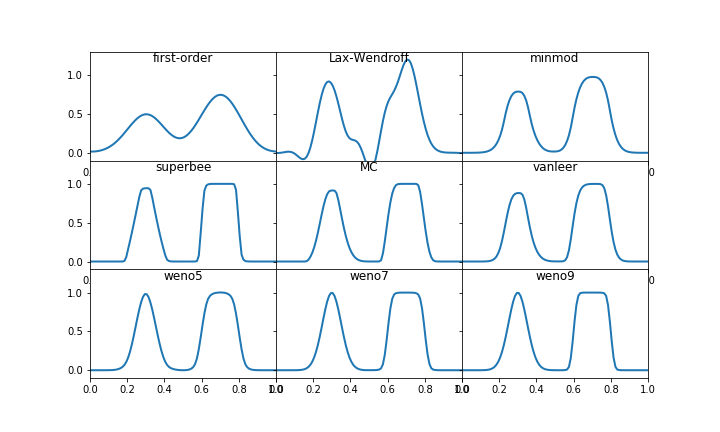
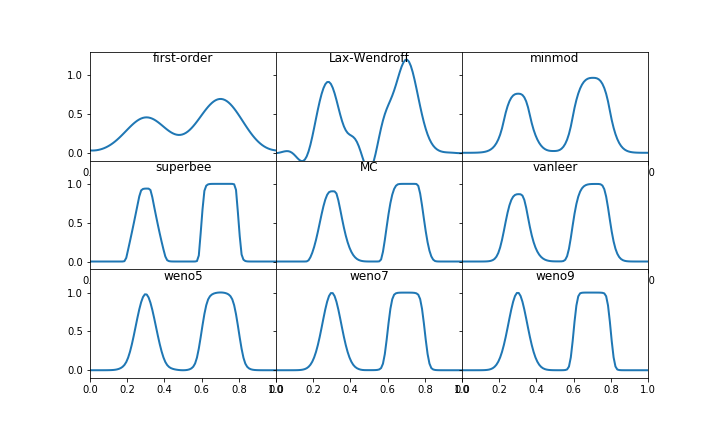
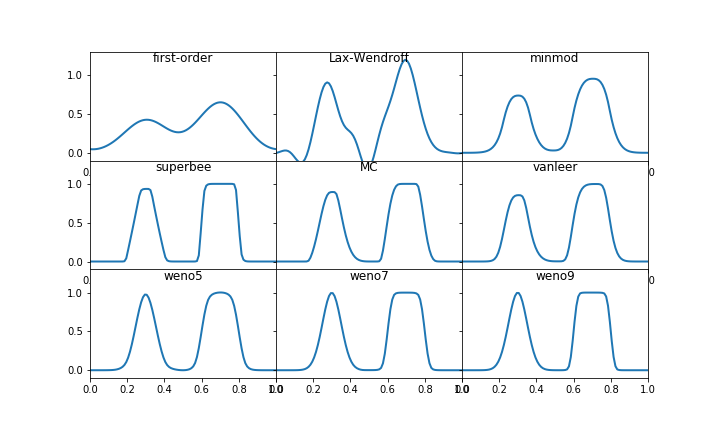
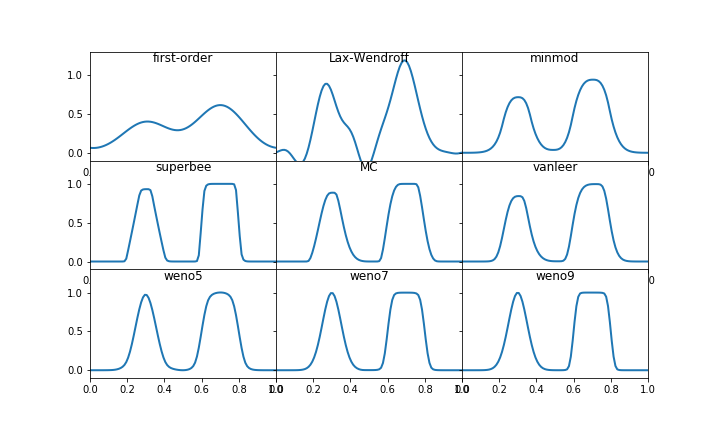
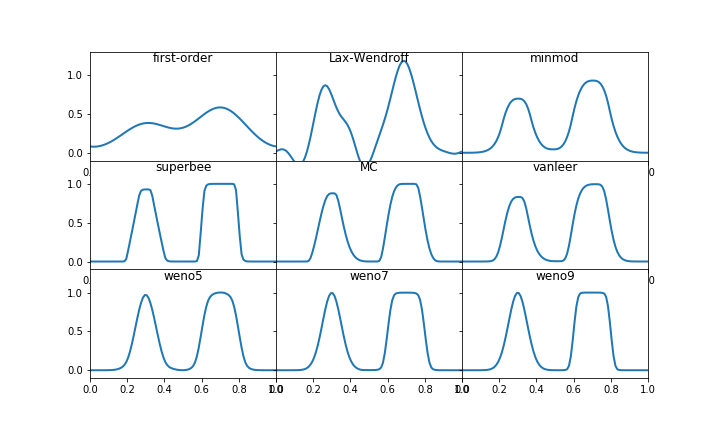
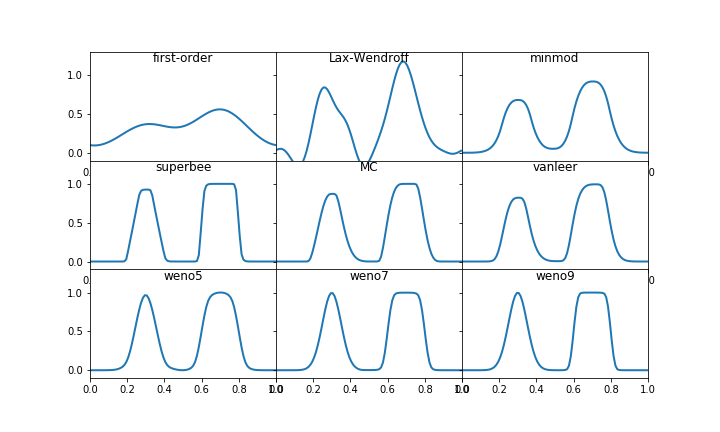
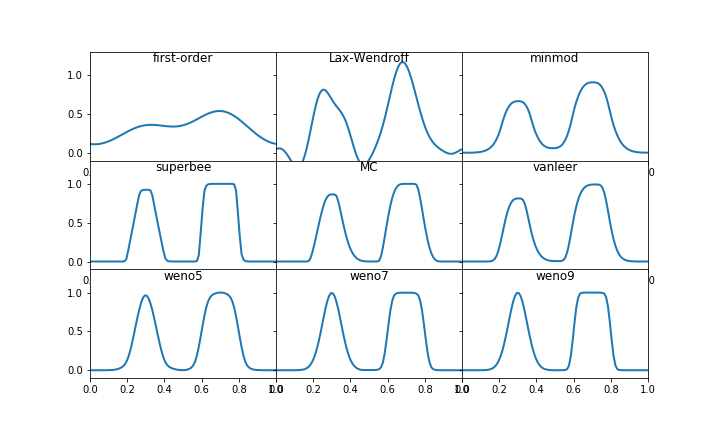

In [11]:
def animate(results,ymin=-0.1):
    fig = plt.figure(figsize=(10,6))

    N = len(results)
    n = int(np.ceil(np.sqrt(N)))
    axes = []
    gs1 = matplotlib.gridspec.GridSpec(n, n)
    gs1.update(wspace=0.,hspace=0.)

    for i in range(n):
        for j in range(n):
            k = n*i + j
            if k<N:
                axes.append(plt.subplot(gs1[i,j]));
                if j>0:
                    axes[-1].yaxis.set_ticklabels(())

    lines = [0]*len(schemes)
    for i in range(len(lines)):
        lines[i], = axes[i].plot([], [], lw=2)

    for i,ax in enumerate(axes):
        ax.set_xlim(0,1); ax.set_ylim(ymin,1.3)
        #ax.legend( [schemes[i] ] )
        ax.set_title(schemes[i], x = 0.5, y=0.85 )
    
    xc = results[0][0].p_centers[0]

    def fplot(frame_number):
        for i, line in enumerate(lines):
            line.set_data(xc,results[i][frame_number].q[0,:])
        return lines,

    return matplotlib.animation.FuncAnimation(fig, fplot, frames=len(claw.frames), interval=300)

animate(results)

It's easy to see the differences in dissipation and dispersion of the various schemes.  Of course, these properties also depend on the CFL number.  Try changing the CFL number in the call to `setup()` above and see how the results change.

### Wavepacket
To see how the limiters affect intermediate frequencies, let's advect a wavepacket.

In [12]:
results = []

for scheme in schemes:
    claw = setup(scheme=scheme,IC='wavepacket',mx=300)
    claw.run()
    results.append(claw.frames)

2019-06-24 12:27:05,248 INFO CLAW: Solution 0 computed for time t=0.000000
2019-06-24 12:27:05,278 INFO CLAW: Solution 1 computed for time t=1.000000
2019-06-24 12:27:05,307 INFO CLAW: Solution 2 computed for time t=2.000000
2019-06-24 12:27:05,335 INFO CLAW: Solution 3 computed for time t=3.000000
2019-06-24 12:27:05,360 INFO CLAW: Solution 4 computed for time t=4.000000
2019-06-24 12:27:05,386 INFO CLAW: Solution 5 computed for time t=5.000000
2019-06-24 12:27:05,410 INFO CLAW: Solution 6 computed for time t=6.000000
2019-06-24 12:27:05,432 INFO CLAW: Solution 7 computed for time t=7.000000
2019-06-24 12:27:05,453 INFO CLAW: Solution 8 computed for time t=8.000000
2019-06-24 12:27:05,475 INFO CLAW: Solution 9 computed for time t=9.000000
2019-06-24 12:27:05,501 INFO CLAW: Solution 10 computed for time t=10.000000
2019-06-24 12:27:05,503 INFO CLAW: Solution 0 computed for time t=0.000000
2019-06-24 12:27:05,525 INFO CLAW: Solution 1 computed for time t=1.000000
2019-06-24 12:27:05,548

2019-06-24 12:27:15,800 INFO CLAW: Animation.save using <class 'clawpack.visclaw.JSAnimation.html_writer.HTMLWriter'>



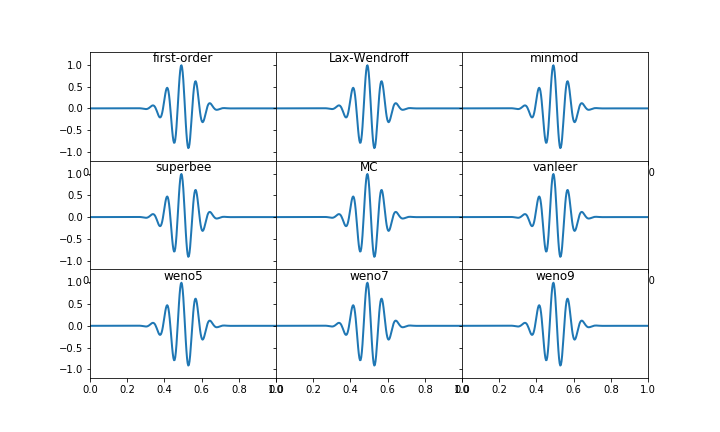
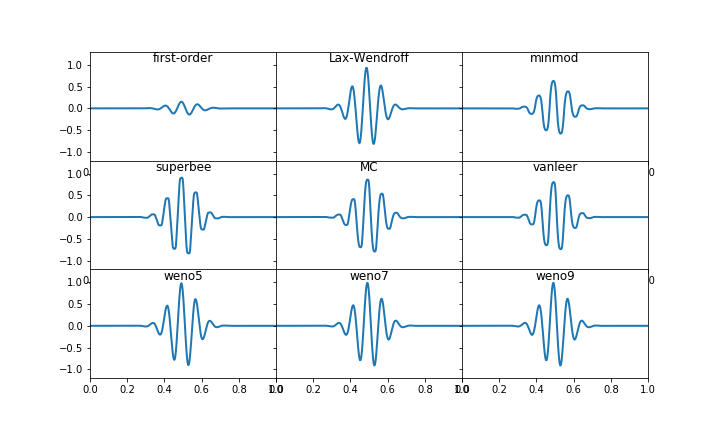
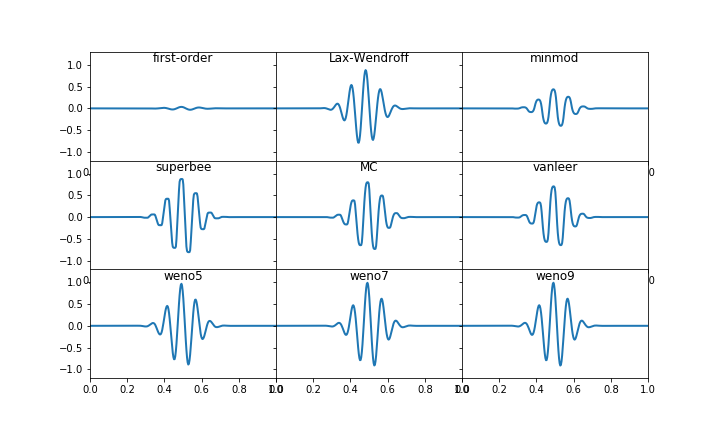
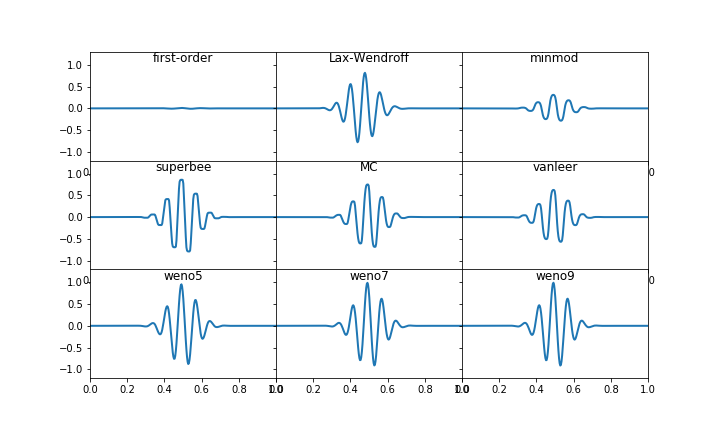
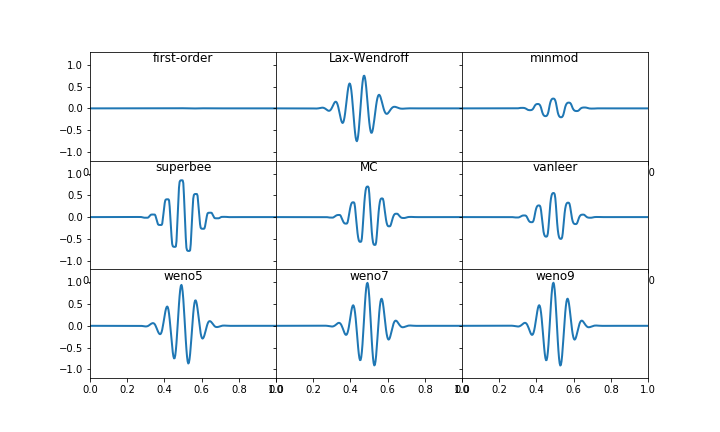
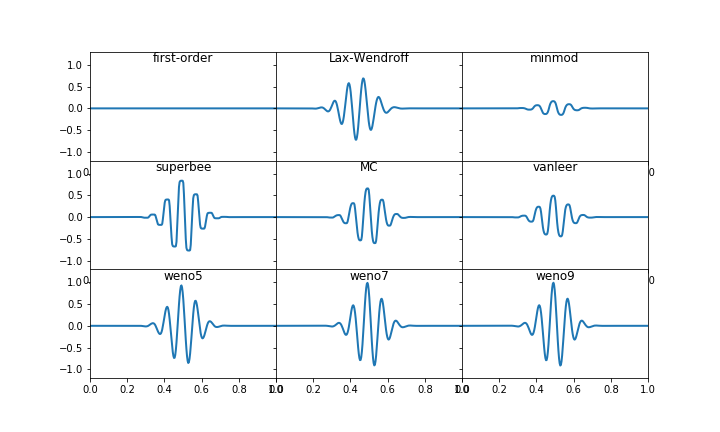
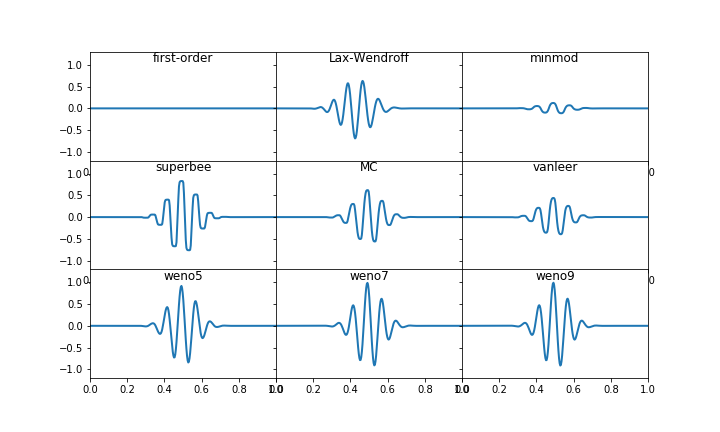
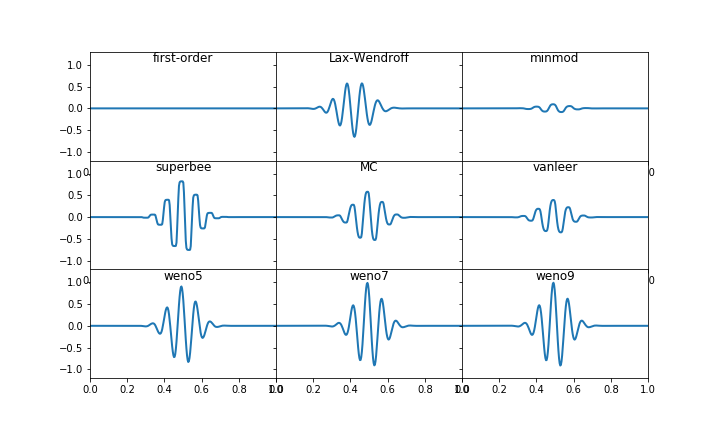
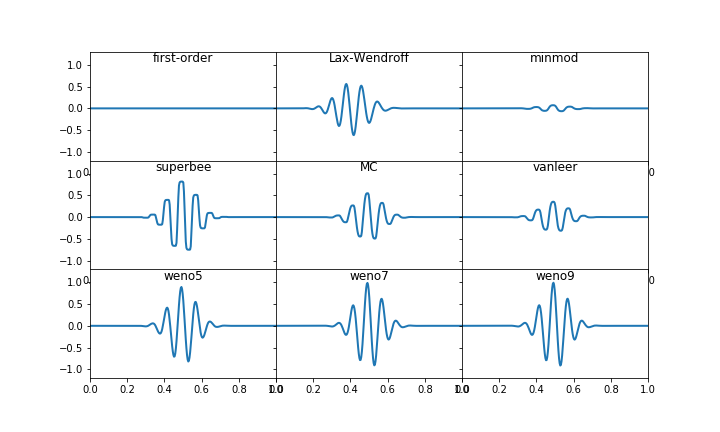
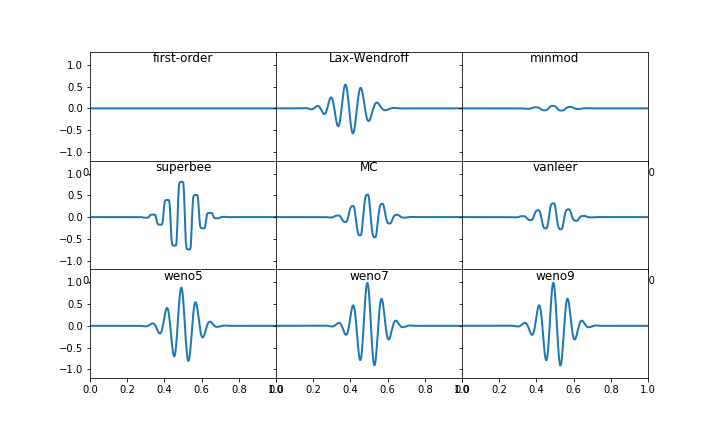
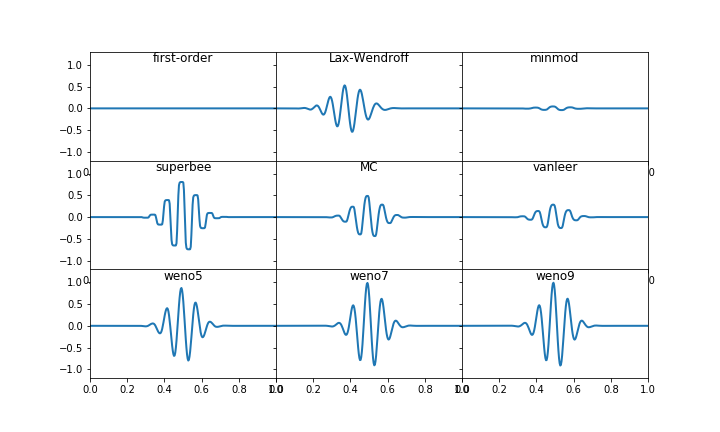

In [13]:
animate(results,ymin=-1.2)